In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# K-Medoids clustering
How is it different from k-means? In k-medoids clustering, real data points are chosen as cluster centers but in k-means, the cluster centroids are calculated using mean, thus an outlier can significantly affect the position of the centroid. In k-medoids, outliers will have less impact because we choose a medoid that minimises the distance to all other points in the cluster. Thus, k-medoids is more robust to outliers.


# importing libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder # we will use one hot encoding to convert "gender" to binary representation (0/1)
from sklearn.metrics import silhouette_score #because clustering is unsupervised, we will use silhouette_score and not performance measures like accuracy, precision etc
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import KMeans
import opendatasets as od
from scipy.spatial.distance import cdist


# reading the dataset

In [6]:
df=pd.read_csv("mall-customers-dataset/Mall_customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# using one hot encoding on gender
Because gender is a categorical feature, we need to encode it, i.e convert it to numbers. Here, males will be assigned 1 and Females 0. Thus, we can represent gender using two binary numbers.
After we are done encoding, we will modify our dataframe to drop the 'Genre' column and instead have 'Gender_male' column where encoded values will be stored. As stated earlier, 1 will represent male and 0 females.

In [8]:
encoder=OneHotEncoder(drop="first",sparse_output=False) #creating an instance
gender_encoded=encoder.fit_transform(df[['Genre']]) # we need to use two square brackets because df['Genre'] is a series but one hot encoder expects a 2d array
df_encoded = df.drop(columns=['Genre'])
df_encoded[['Gender_Male']] = gender_encoded
df_encoded.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,1,19,15,39,1.0
1,2,21,15,81,1.0
2,3,20,16,6,0.0
3,4,23,16,77,0.0
4,5,31,17,40,0.0


# Feature selection and then scaling
Feature scaling is important because it ensures that all variables contribute equally to distance-based algorithms like k-Means and k-Medoids. Without scaling, features with larger ranges dominate, leading to biased clustering. Standardization transforms features to have zero mean and unit variance, improving convergence and cluster accuracy. 

In [10]:
X = df_encoded[['Age','Annual Income (k$)', 'Spending Score (1-100)']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)
X_final = np.hstack((X_scaled, df_encoded[['Gender_Male']].values)) # horizontally stack the 'Gender_Male' column in the matrix

[[-1.42456879 -1.73899919 -0.43480148]
 [-1.28103541 -1.73899919  1.19570407]
 [-1.3528021  -1.70082976 -1.71591298]
 [-1.13750203 -1.70082976  1.04041783]
 [-0.56336851 -1.66266033 -0.39597992]
 [-1.20926872 -1.66266033  1.00159627]
 [-0.27630176 -1.62449091 -1.71591298]
 [-1.13750203 -1.62449091  1.70038436]
 [ 1.80493225 -1.58632148 -1.83237767]
 [-0.6351352  -1.58632148  0.84631002]
 [ 2.02023231 -1.58632148 -1.4053405 ]
 [-0.27630176 -1.58632148  1.89449216]
 [ 1.37433211 -1.54815205 -1.36651894]
 [-1.06573534 -1.54815205  1.04041783]
 [-0.13276838 -1.54815205 -1.44416206]
 [-1.20926872 -1.54815205  1.11806095]
 [-0.27630176 -1.50998262 -0.59008772]
 [-1.3528021  -1.50998262  0.61338066]
 [ 0.94373197 -1.43364376 -0.82301709]
 [-0.27630176 -1.43364376  1.8556706 ]
 [-0.27630176 -1.39547433 -0.59008772]
 [-0.99396865 -1.39547433  0.88513158]
 [ 0.51313183 -1.3573049  -1.75473454]
 [-0.56336851 -1.3573049   0.88513158]
 [ 1.08726535 -1.24279661 -1.4053405 ]
 [-0.70690189 -1.24279661

# computing distance matrix and applying kmedoids

In [12]:
distance_matrix = cdist(X_scaled, X_scaled, metric='euclidean')# calculating distance (euclidean) of each point from the other in the dataframe
initial_medoids = [0, (len(X_final)//2), len(X_final) - 1] #3 initial clusters are being assigned, the starting index, the middle and the end
kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')#initialising
kmedoids_instance.process()# creating an instance, starting the process
kmedoids_labels = np.zeros(len(X_final),dtype=int)#initialises an array with zeroes, the array size is equal to the length of the final dataframe
for cluster_index, cluster in enumerate(kmedoids_instance.get_clusters()): #cluster_index are the indices of the three clusters (0,1,2) and cluster is the sublist
    for index in cluster:# index represent the individual data points in each cluster
        kmedoids_labels[index] = cluster_index #for every point in a particular cluster, we assign kmedoids_labels[index] the value of the medoid

In [13]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_final)

# Silhouette score
what is silhouette score? it is calculated as (b-a)/max(a,b)
- here, a is average distance between points in same cluster (should be less)
- b is average distance to points in the nearest different cluster (should be more)

So, a silhouette score of close to 1 shows well clustered data, a silhouette score of 0 shows misclassified clusters and of -1 shows misclassified points

In [15]:
kmedoids_score=silhouette_score(X_final,kmedoids_labels)
kmeans_score=silhouette_score(X_final,kmeans_labels)
print(f"Kmedoids {kmedoids_score:.5f}")
print(f"Kmeans {kmeans_score:.5f}")

Kmedoids 0.31588
Kmeans 0.31201


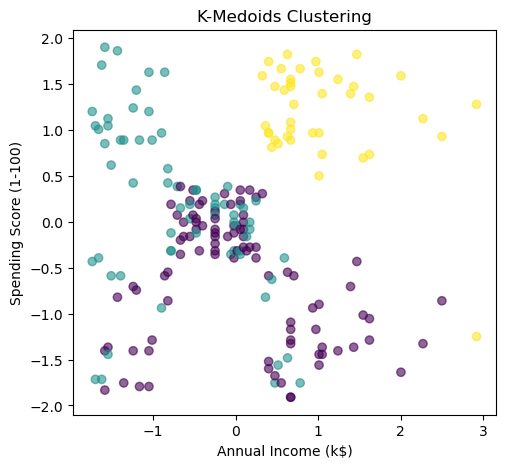

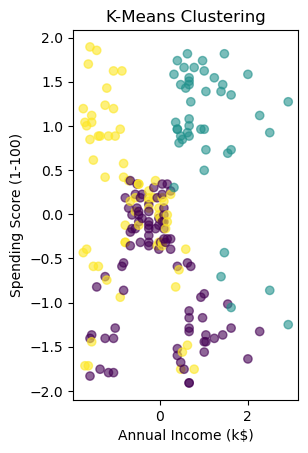

In [16]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='viridis', alpha=0.6)  
    plt.title(title)
    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1-100)")
    plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_final, kmedoids_labels, "K-Medoids Clustering")

plt.subplot(1, 2, 2)
plot_clusters(X_final, kmeans_labels, "K-Means Clustering")

# why is the silhouette score for both the algorithms nearly same?
The silhouette scores for K-Medoids (0.31588) and K-Means (0.31201) are very close, indicating minimal improvement. K-Medoids is more robust to outliers since it selects actual data points as medoids, but if the dataset lacks significant outliers or has well-separated clusters, this advantage is reduced. Both methods produce visually similar clusters, suggesting that the data distribution does not strongly favor K-Medoids. K-Medoids is typically better for non-Euclidean distances or categorical data, but for numerical data, K-Means remains competitive due to its efficiency.